## Imports and loader funcitons


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import cv2
import numpy as np
import PIL
import os
import re

In [2]:
def imshow(img):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img).convert("RGB"))
    
def imshow_on_axis(img, ax, title):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

            
def load_images_from_path(path, number):
    images = []
    srcs = []
    pattern = rf"^{number}(?!\d)"
    
    for filename in os.listdir(path):
        if re.match(pattern, filename):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                images.append(img)
                srcs.append(filename)

    return images, srcs


def load_images(number):
    final_images = []
    final_srcs = []

    final_path = f"data/final_submissions/{number}/"
    web_path = "data/web/"
    ai_path = "data/ai/"

    if not os.path.exists(final_path):
        print(f"The final submissions path '{final_path}' does not exist.")
        return None, None, None

    for filename in os.listdir(final_path):
        img = cv2.imread(os.path.join(final_path, filename))
        if img is not None:
            final_images.append(img)
            final_srcs.append(f"{number}_{filename}")

    web_images, web_srcs = load_images_from_path(web_path, number)
    ai_images, ai_srcs = load_images_from_path(ai_path, number)

    if not final_images:
        print(f"No images found in '{final_path}'. Please check the contents.")
        return None, None, None

    if not web_images and not ai_images:
        print(
            f"The number '{number}' does not correspond to any valid images in 'web' or 'ai' folders."
        )
        return None, None, None

    if not web_images:
        print(f"No web images found with prefix '{number}' in '{web_path}'.")
        return None, None, None
    if not ai_images:
        print(f"No AI images found with prefix '{number}' in '{ai_path}'.")
        return None, None, None

    return final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs

In [3]:
def read_csv(path):
    try:
        df = pd.read_csv(path)
        return df
    except Exception as e:
        print(f"Error reading the file: {e}")
        return None

## Analyze of plots


In [4]:
resnets_temp=[]
new_columns = ["Final_Submission", "Inspiration", "Similarity"]

for i in range(1,26):
    resnets_temp.append(read_csv(f"csv/csv2/{i}.csv"))
#Temp fix cause we still dont have all data for 26 group
resnets_temp.append(read_csv(f"csv/csv2/27.csv"))

resnets = pd.concat(resnets_temp, ignore_index=True)
resnets.columns = new_columns
resnets["Final_Submission"] = resnets["Final_Submission"].apply(lambda x: "_".join(x.split('/')[-2:]))
resnets["Inspiration"] = resnets["Inspiration"].apply(lambda x: x.split('/')[-1])


colors = read_csv("csv/color_similarity.csv")

dinos=read_csv("csv/dino_similarity.csv")
dinos.columns = new_columns
dinos["Final_Submission"] = dinos["Final_Submission"].apply(lambda x: "_".join(x.split('\\')[-2:]))
dinos["Inspiration"] = dinos["Inspiration"].apply(lambda x: x.split('\\')[-1])

contrasts = read_csv("csv/contrast_similarity.csv")
contrasts.columns = new_columns
contrasts["Final_Submission"] = contrasts["Final_Submission"].apply(lambda x: "_".join(x.split('\\')[-2:]))
contrasts["Inspiration"] = contrasts["Inspiration"].apply(lambda x: x.split('\\')[-1])

print(colors.shape)
print(resnets.shape)
print(dinos.shape)
print(contrasts.shape)

(8620, 3)
(8620, 3)
(8620, 3)
(8664, 3)


In [5]:
colors.head()

Final_Submission Inspiration  Similarity
0          1_1.png    1A_1.jpg    0.622241
1          1_1.png   1A_10.jpg    0.886676
2          1_1.png    1A_2.jpg    0.800207
3          1_1.png    1A_3.jpg    0.775083
4          1_1.png    1A_4.jpg    0.815200

In [6]:
resnets.head()

Final_Submission  Inspiration  Similarity
0          1_1.png    1A_11.png    0.818425
1          1_1.png    1A_12.png    0.818425
2          1_1.png    1A_13.png    0.826663
3          1_1.png    1B_11.png    0.843834
4          1_1.png  1B_12_1.png    0.812419

In [7]:
dinos.head()

Final_Submission  Inspiration  Similarity
0          1_8.png    1A_11.png    0.562734
1          1_8.png    1A_12.png    0.562734
2          1_8.png    1A_13.png    0.596446
3          1_8.png    1B_11.png    0.566994
4          1_8.png  1B_12_1.png    0.561020

In [8]:
contrasts.head()

Final_Submission  Inspiration  Similarity
0          1_5.png    1A_11.png    0.933009
1          1_5.png    1A_12.png    0.933009
2          1_5.png    1A_13.png    0.927407
3          1_5.png    1B_11.png    0.976822
4          1_5.png  1B_12_1.png    0.942295

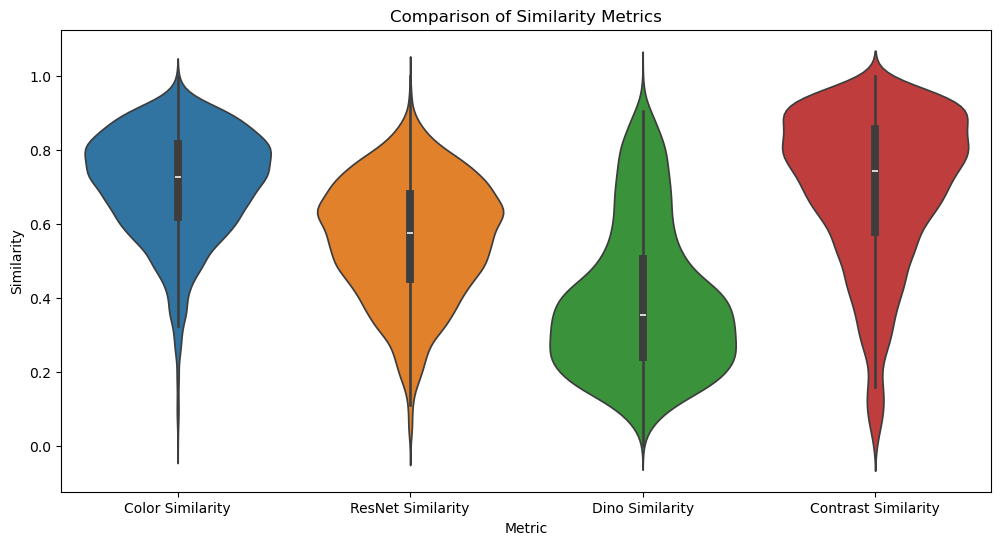

In [9]:
csv_files =[
    colors,
    resnets,
    dinos,
    contrasts
    ]
def zero_one_scale(x:pd.Series):
    return (x-x.min())/(x.max()-x.min())

def standard_scale(x:pd.Series):
    return (x-x.mean())/x.std()


for file in csv_files:
    file["Similarity"] = zero_one_scale(file["Similarity"])
    
metrics = ["Color Similarity", "ResNet Similarity", "Dino Similarity", "Contrast Similarity"]

# Combine each metric into a single DataFrame with a new 'Metric' column
dfs = []
for csv_file, metric in zip(csv_files, metrics):
    df = csv_file.copy()
    df['Metric'] = metric  # Add a column for metric type
    dfs.append(df)

# Concatenate all DataFrames
all_data = pd.concat(dfs, ignore_index=True)

# Plot the violin plot with metric type as hue
#plt.figure(figsize=(7.5, 3*len(csv_files)))
plt.figure(figsize=(3*len(csv_files), 6))
sns.violinplot(data=all_data, x="Metric", y="Similarity", hue="Metric")
plt.title("Comparison of Similarity Metrics")
plt.ylabel("Similarity")
plt.xlabel("Metric")
plt.show()

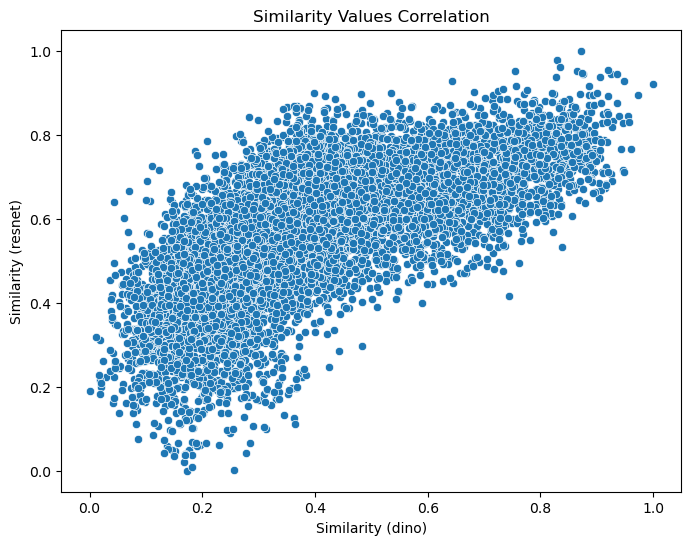

Correlation coefficient: 0.6837753366902165


In [10]:
# Merge the two dataframes on 'Final_Submission' and 'Inspiration'
merged_df = pd.merge(dinos, resnets, on=['Final_Submission', 'Inspiration'], suffixes=('_df1', '_df2'))

# Plot the correlation using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='Similarity_df1', y='Similarity_df2')
plt.title('Similarity Values Correlation')
plt.xlabel('Similarity (dino)')
plt.ylabel('Similarity (resnet)')
plt.show()

# Compute and print the correlation coefficient
correlation = merged_df['Similarity_df1'].corr(merged_df['Similarity_df2'])
print(f'Correlation coefficient: {correlation}')

In [11]:
merge_all = pd.merge(
    pd.merge(
        colors,
        resnets,
        on=["Final_Submission", "Inspiration"],
        suffixes=("_colors", "_resnets")),
    pd.merge(
        dinos,
        contrasts,
        on=["Final_Submission", "Inspiration"],
        suffixes=("_dinos", "_contrasts")),
    on=["Final_Submission", "Inspiration"],
)
merge_all.columns = ["Final_Submission", "Inspiration", "Color_Similarity", "ResNet_Similarity", "Dino_Similarity","Contrast_Similarity"]
merge_all.head()

Final_Submission Inspiration  Color_Similarity  ResNet_Similarity  \
0          1_1.png    1A_1.jpg          0.529821           0.797856   
1          1_1.png   1A_10.jpg          0.858951           0.604741   
2          1_1.png    1A_2.jpg          0.751328           0.615733   
3          1_1.png    1A_3.jpg          0.720056           0.551096   
4          1_1.png    1A_4.jpg          0.769988           0.652863   

   Dino_Similarity  Contrast_Similarity  
0         0.775847             0.744530  
1         0.586041             0.624540  
2         0.303534             0.883636  
3         0.340668             0.869095  
4         0.453489             0.813474

<Axes: >

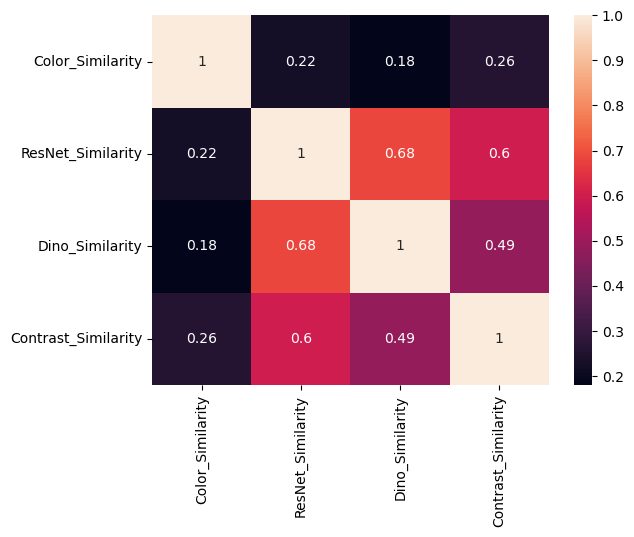

In [12]:
value_cols = ["Color_Similarity", "ResNet_Similarity", "Dino_Similarity", "Contrast_Similarity"]
sns.heatmap(merge_all[value_cols].corr(), annot=True)

## See bar plots of most simmilairty


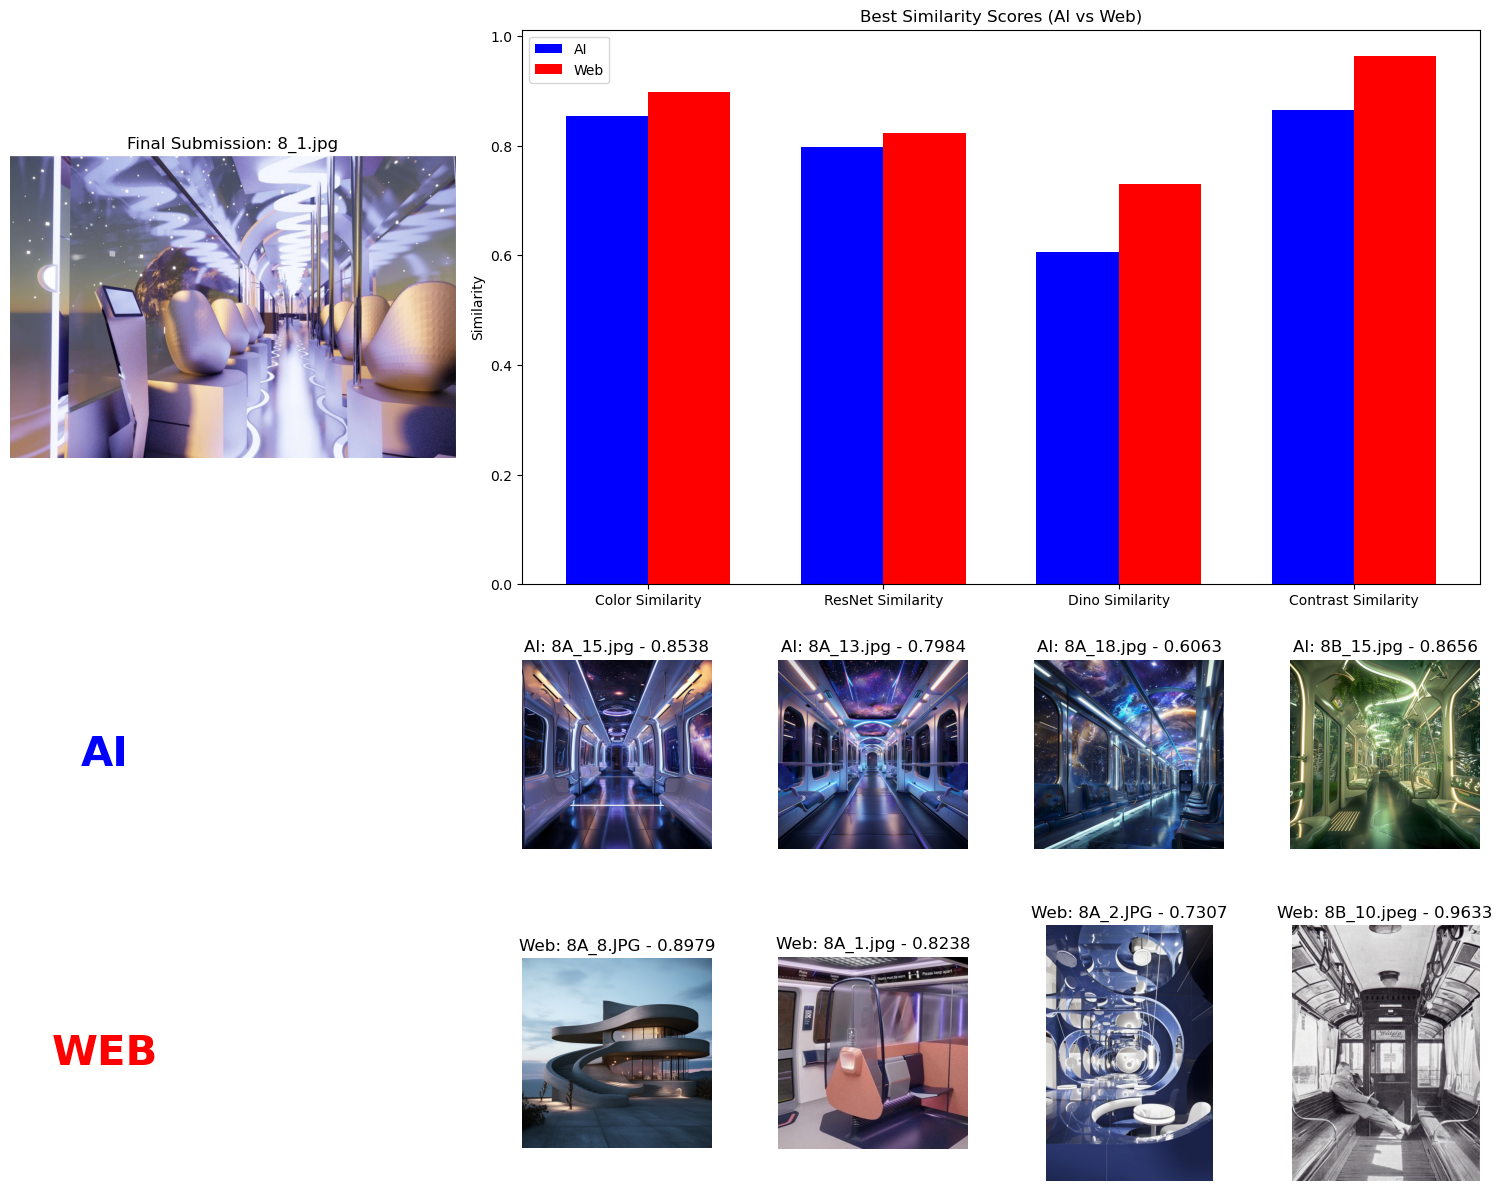

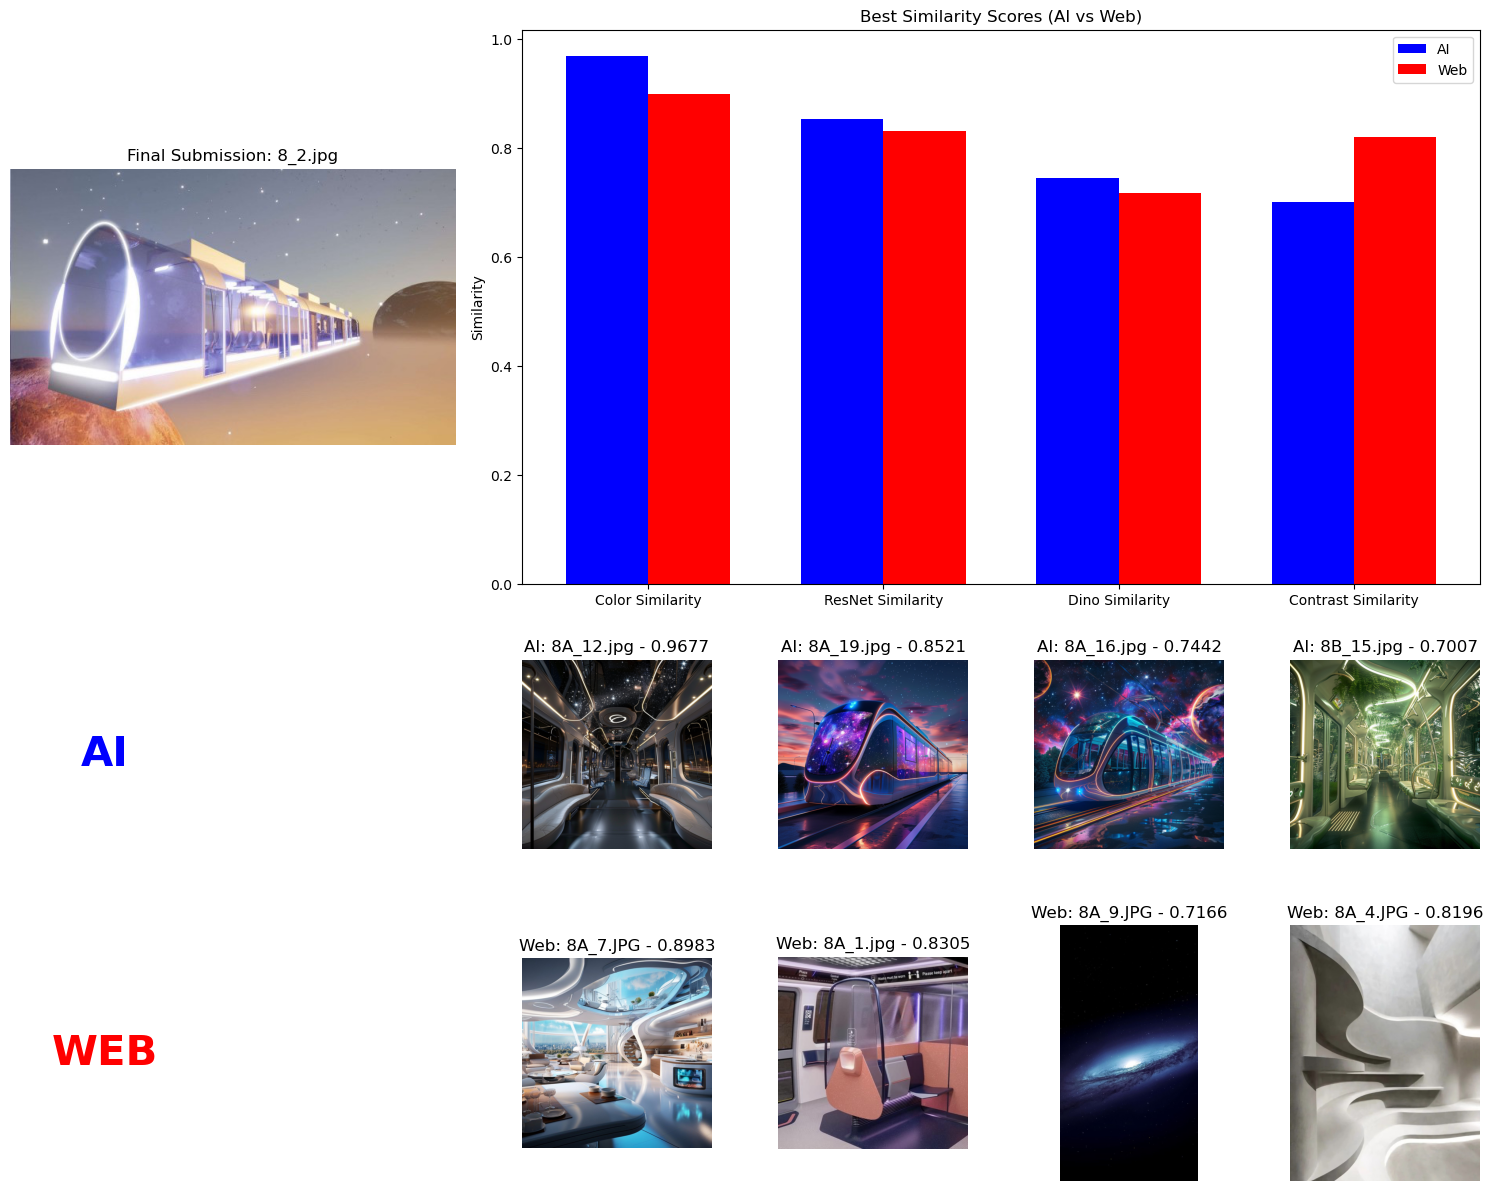

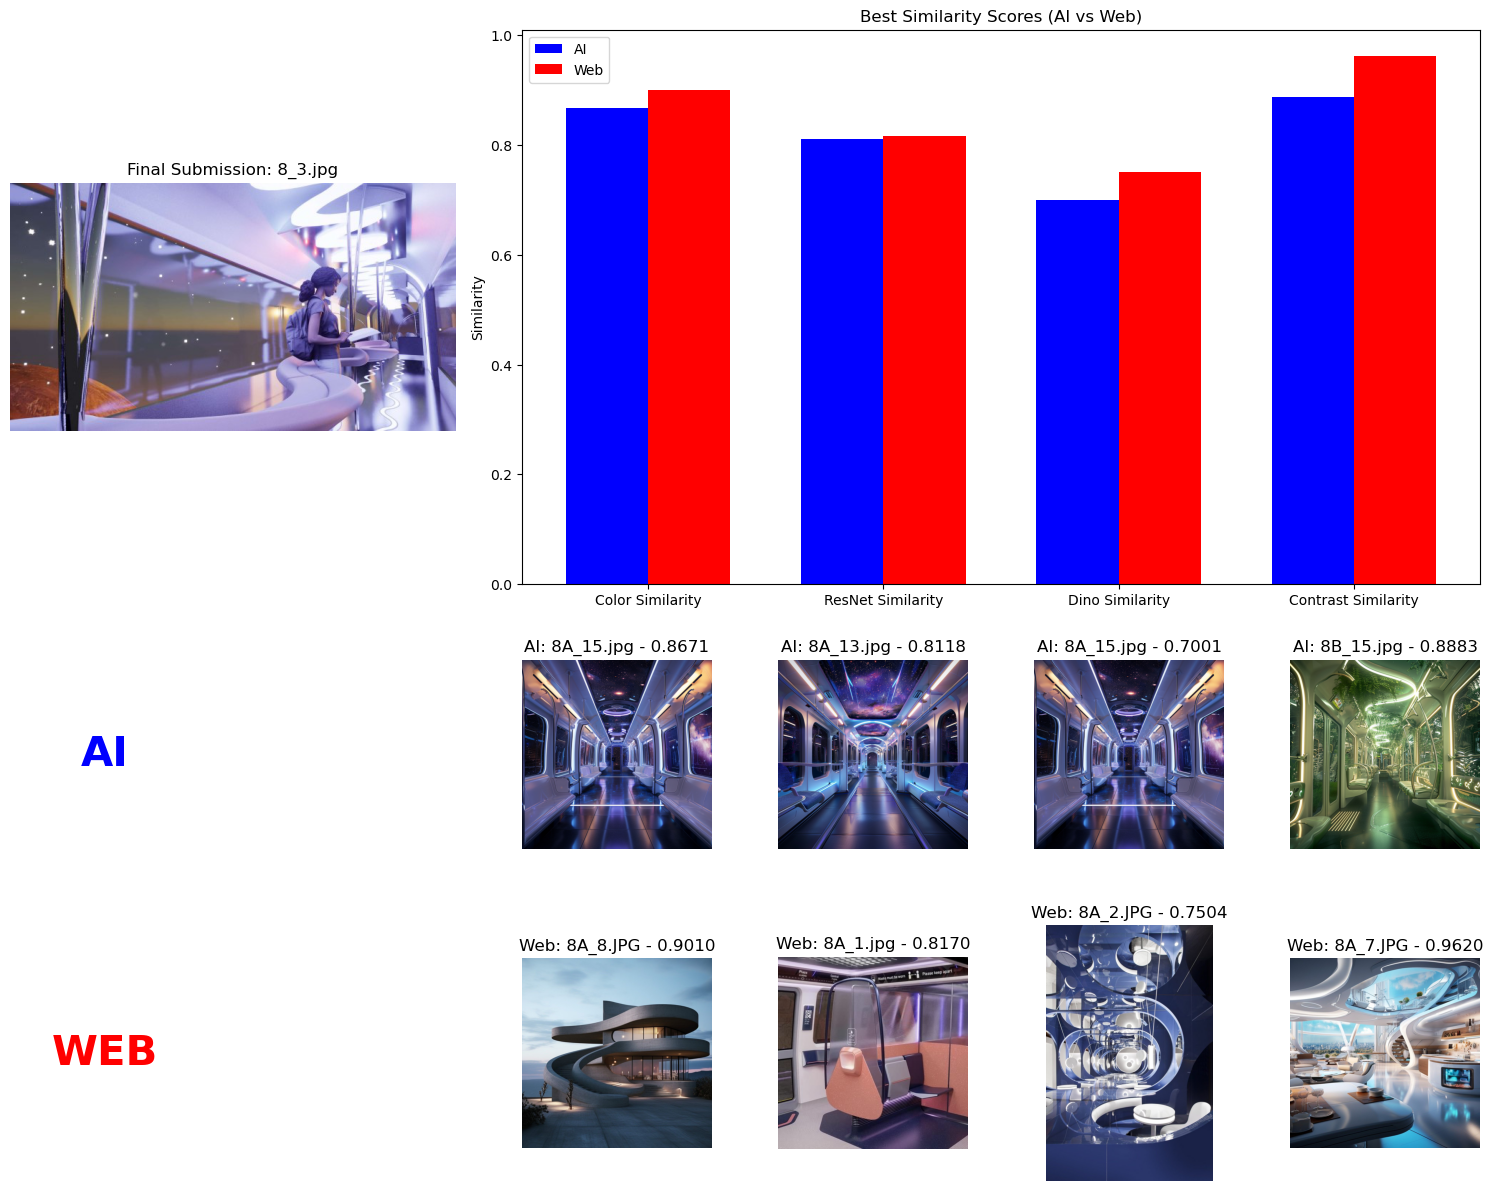

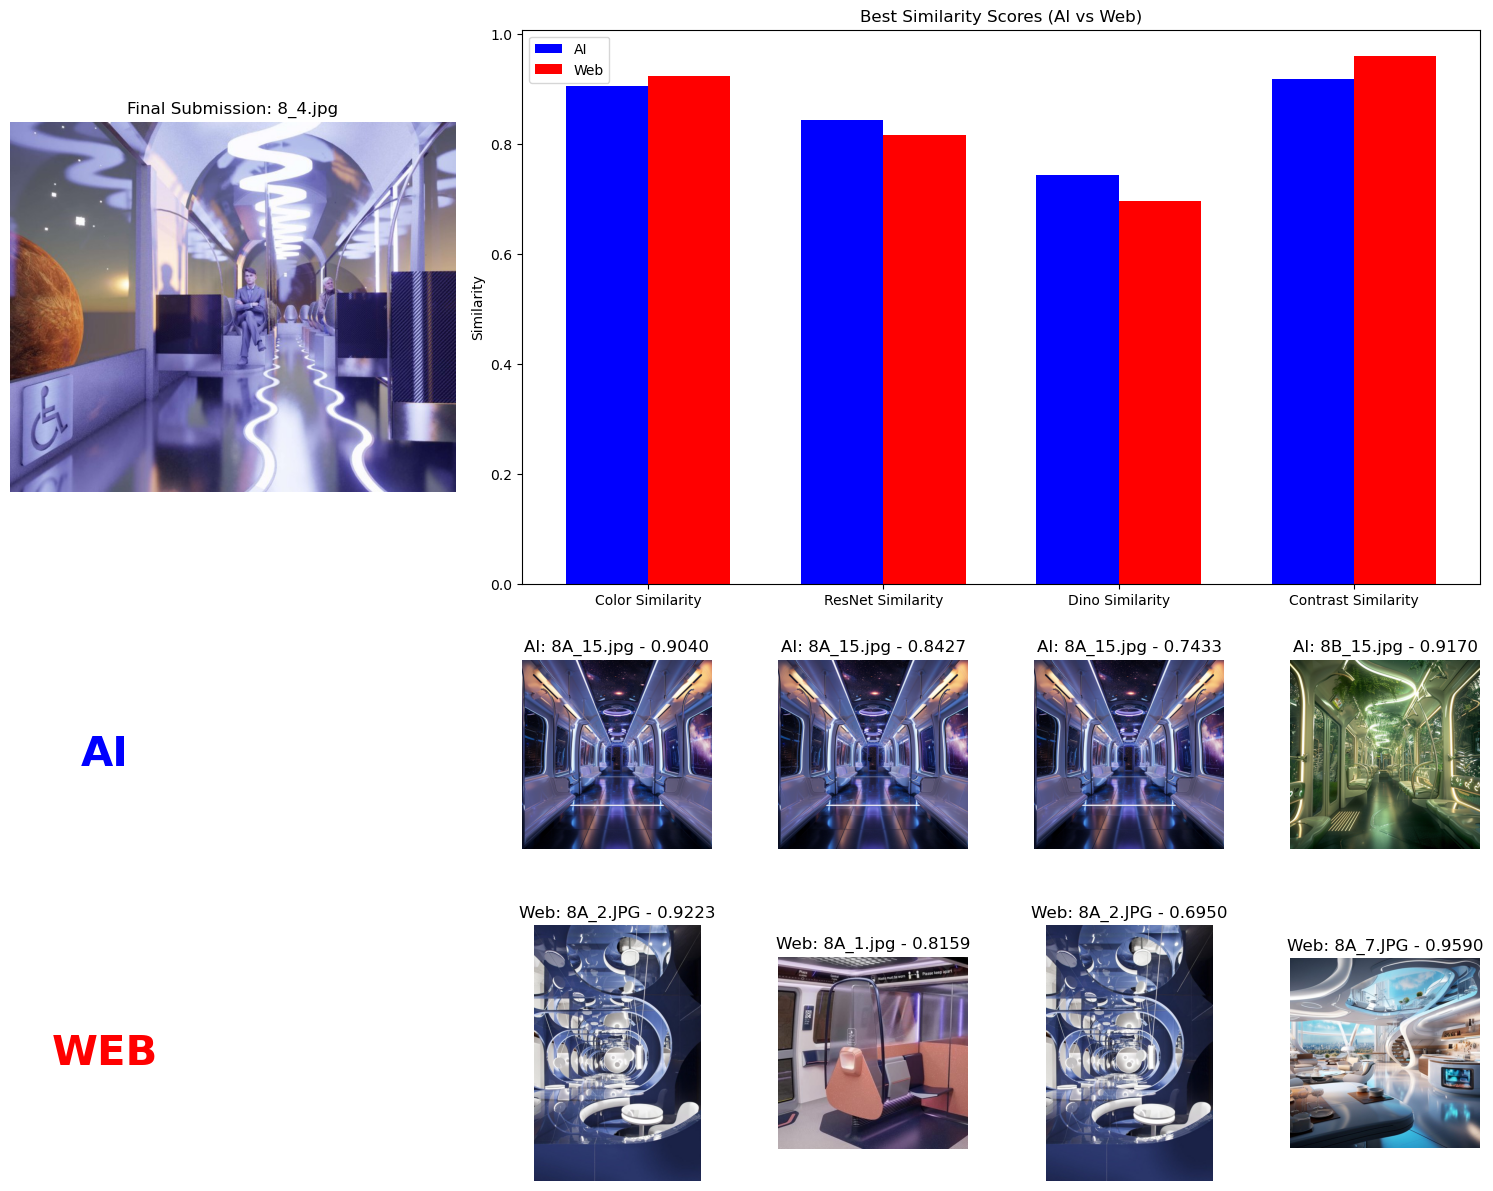

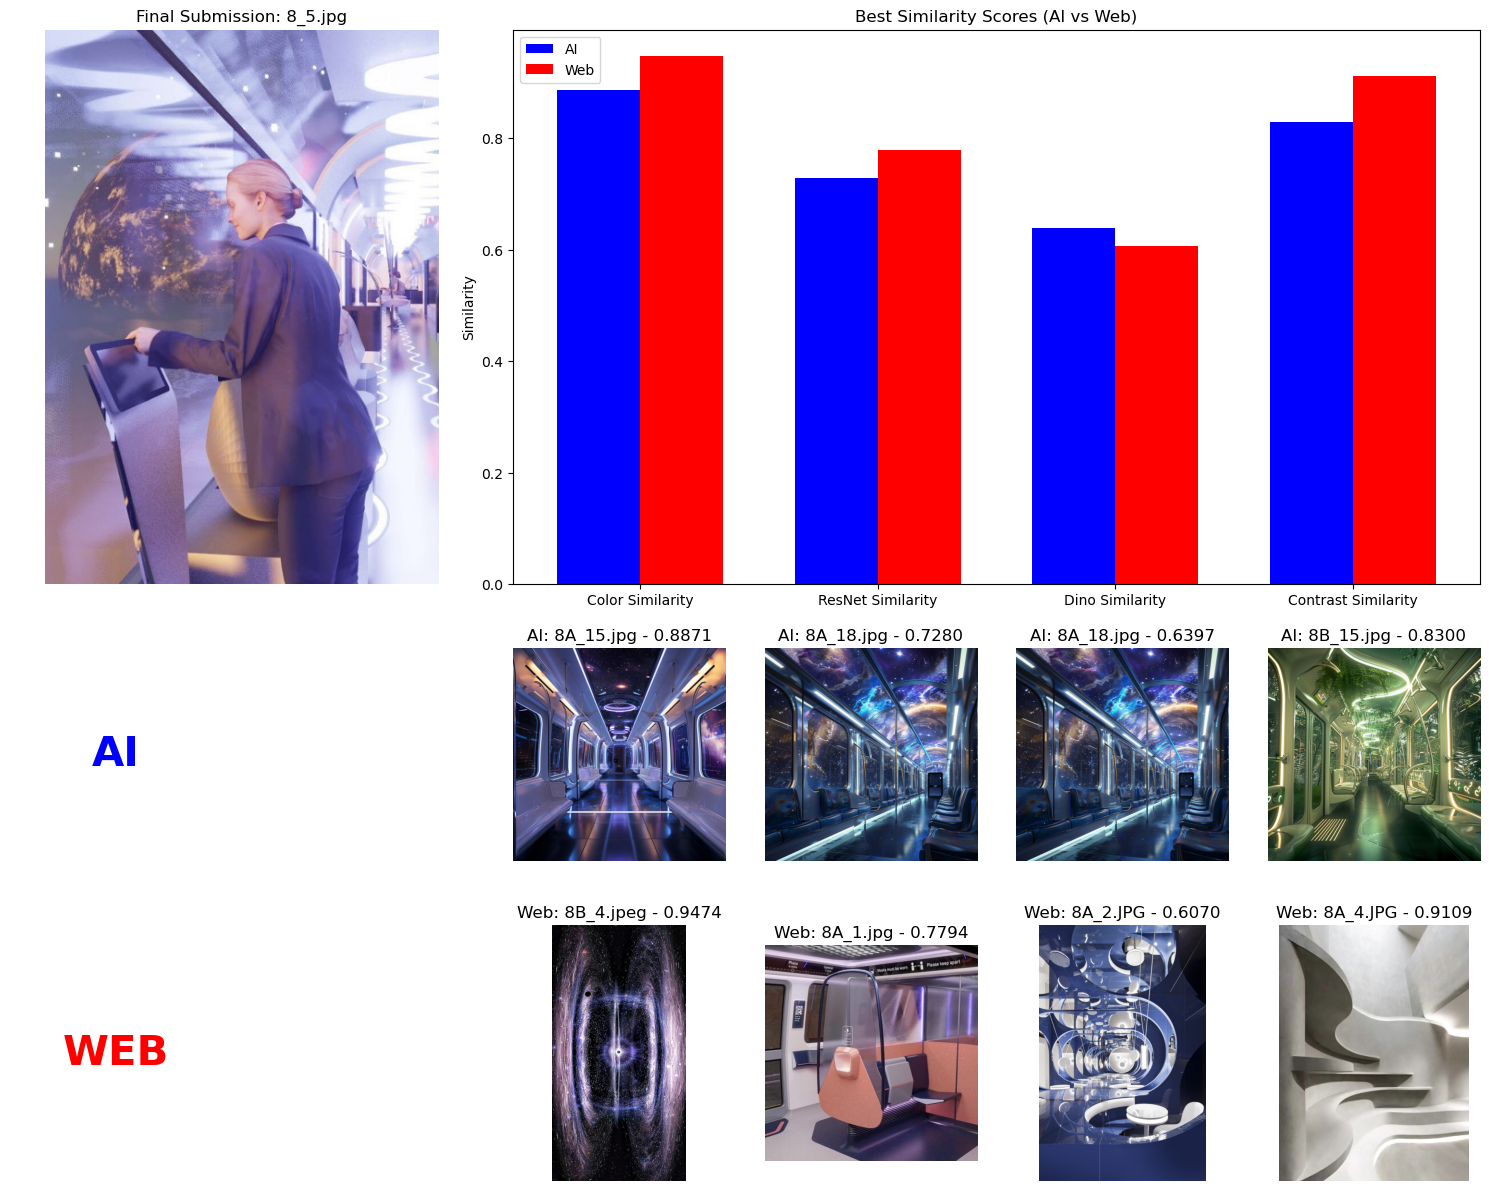

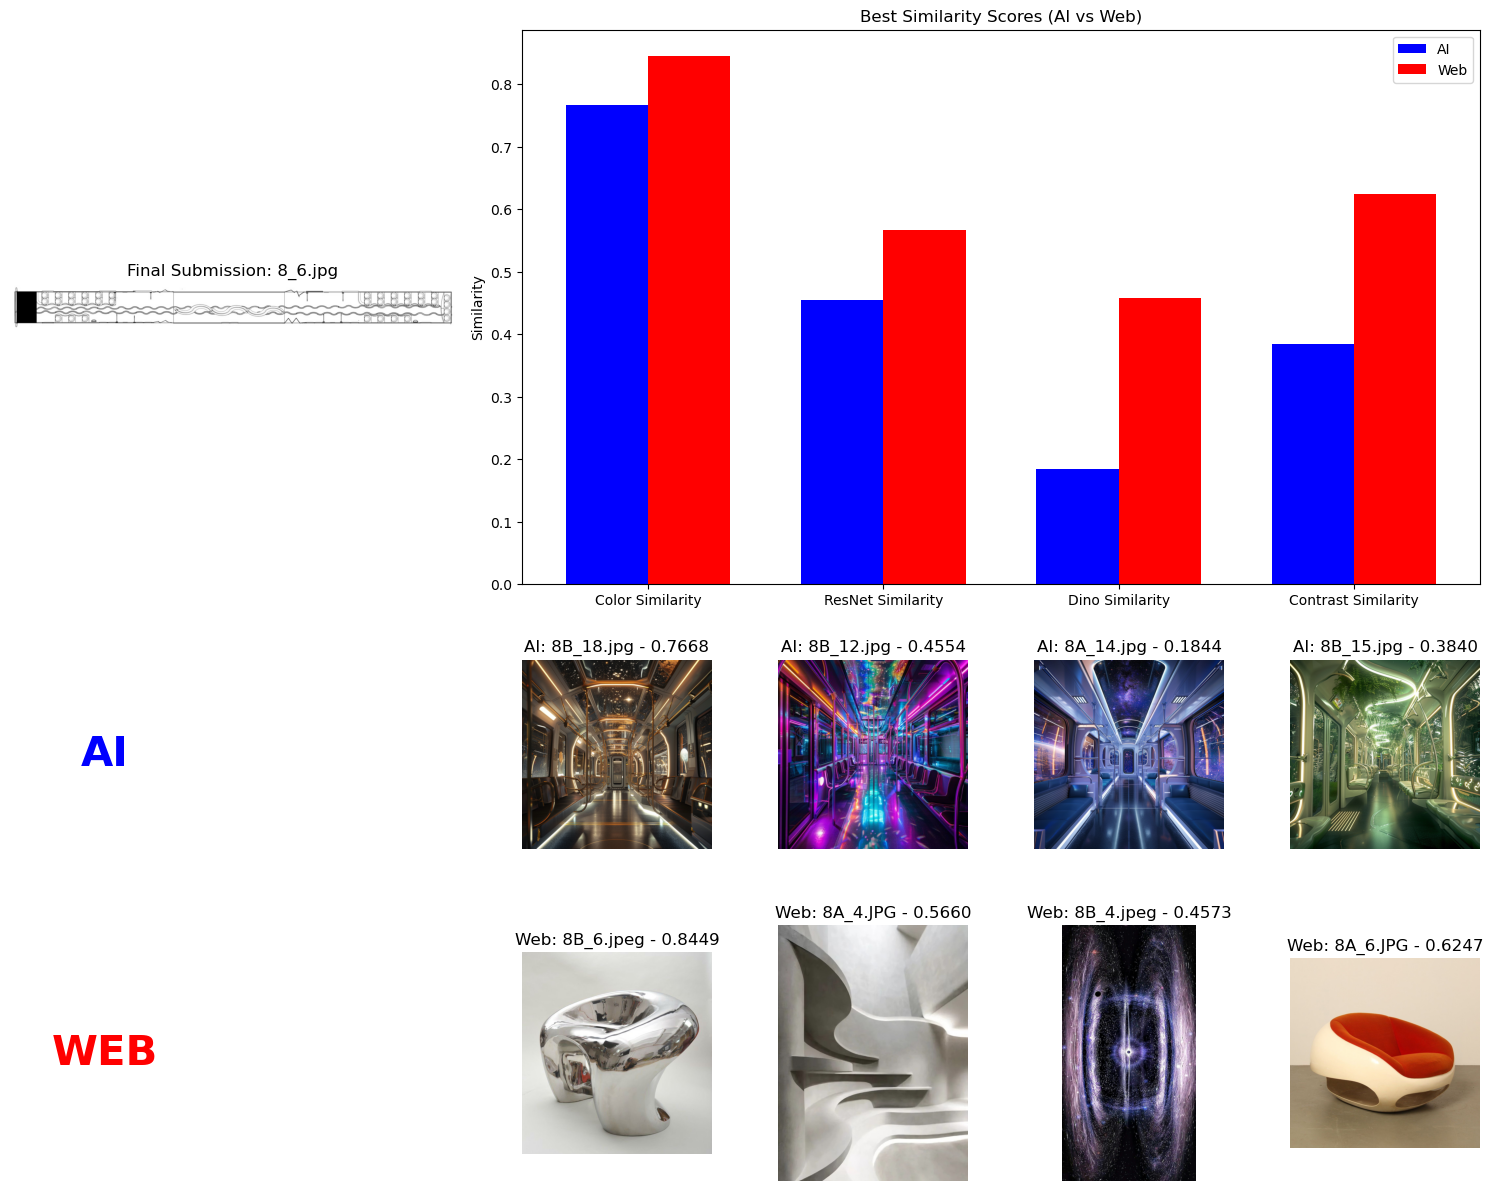

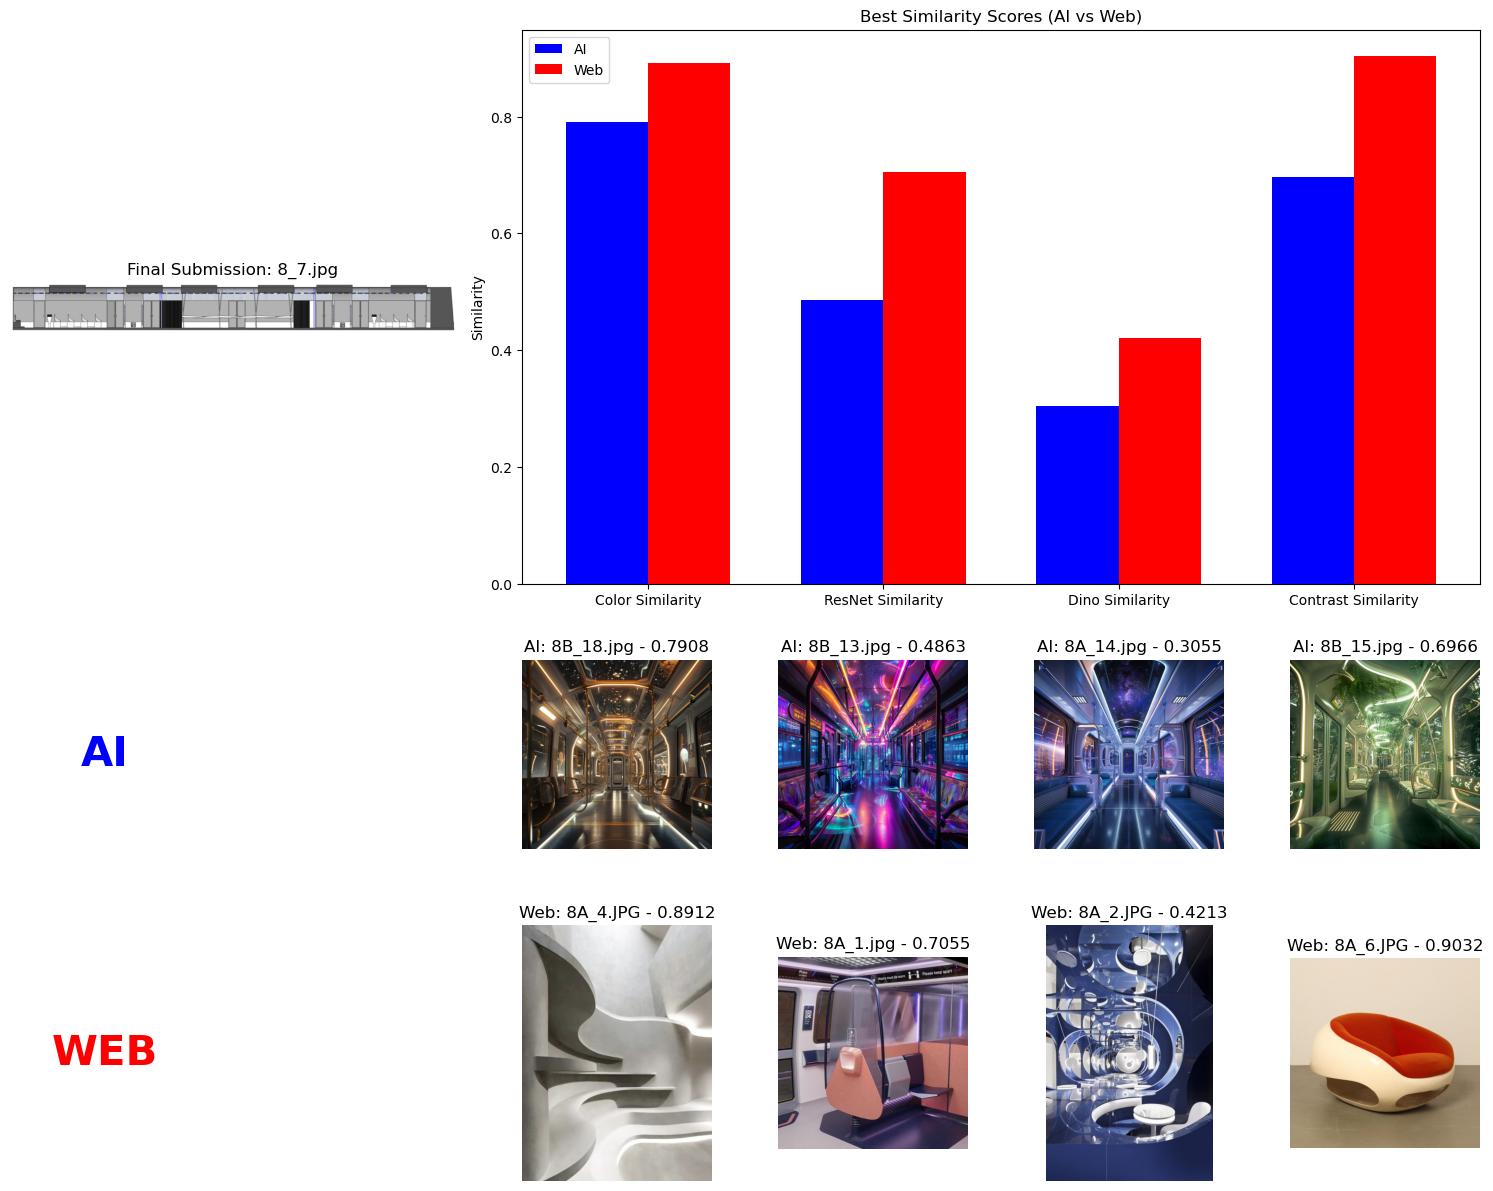

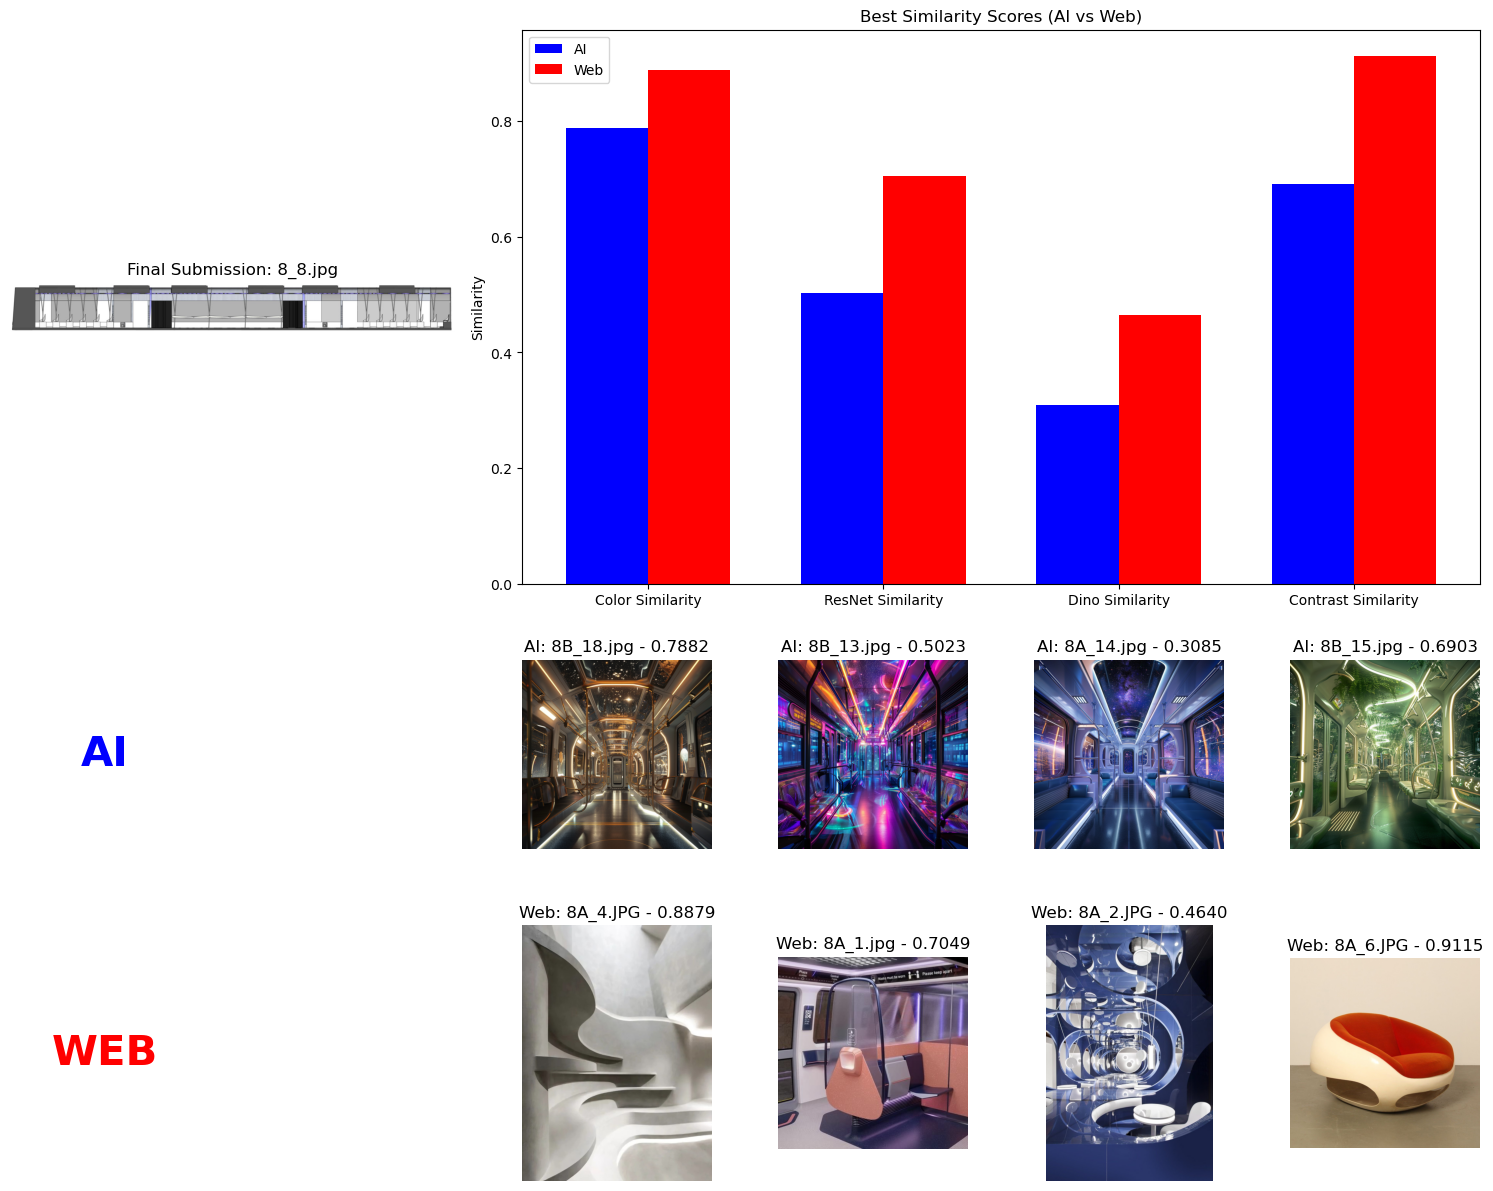

In [13]:
def show_simmilarity(group_id, csv_files):
    final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs = load_images(group_id)
    
    for i in range (len(final_srcs)):
        final_src = final_srcs[i]
        final_image=final_images[i]
        
        ai_sims=[] #color, resnet, dino
        ai_sims_srcs=[]
        
        web_sims=[]
        web_sims_srcs=[]
        
        for csv_file in csv_files:
            final_df = csv_file[csv_file['Final_Submission'] == final_src]
            
            web_df= final_df[final_df['Inspiration'].isin(web_srcs)]
            web_df= web_df.sort_values(by='Similarity', ascending=False)
            #web_sims.append(web_df.iloc[0]['Similarity'])
            web_sims.append(web_df['Similarity'].max())
            web_sims_srcs.append(web_df.iloc[0]['Inspiration'])
            
            ai_df= final_df[final_df['Inspiration'].isin(ai_srcs)]
            ai_df= ai_df.sort_values(by='Similarity', ascending=False)
            #ai_sims.append(ai_df.iloc[0]['Similarity'])
            ai_sims.append(ai_df['Similarity'].max())
            ai_sims_srcs.append(ai_df.iloc[0]['Inspiration'])
            
        
        fig = plt.figure(figsize=(15, 15))
        gs = GridSpec(5, 6, figure=fig)


        ax_final_submission = fig.add_subplot(gs[0:2, 0:2])  
        imshow_on_axis(final_image, ax_final_submission, f"Final Submission: {final_src}")
        
        ax = fig.add_subplot(gs[2, 0])  # ax for 3,0
        ax.text(0.5, 0.5, 'AI', fontsize=30, fontweight='bold', ha='center', va='center', color='blue')
        ax.axis('off')
        
        
        ax = fig.add_subplot(gs[3, 0])  # ax for 3,0
        ax.text(0.5, 0.5, 'WEB', fontsize=30, fontweight='bold', ha='center', va='center', color='red')
        ax.axis('off')
        
        for i in range(len(csv_files)):
            web_score = web_sims[i]
            web_image = web_images[web_srcs.index(web_sims_srcs[i])]
            
            ai_score = ai_sims[i]
            ai_image = ai_images[ai_srcs.index(ai_sims_srcs[i])]
            
            ax_web = fig.add_subplot(gs[3, i+2])
            imshow_on_axis(web_image, ax_web, f"Web: {web_sims_srcs[i]} - {web_score:.4f}")
            
            ax_ai = fig.add_subplot(gs[2, i+2])
            imshow_on_axis(ai_image, ax_ai, f"AI: {ai_sims_srcs[i]} - {ai_score:.4f}")
            
        
            
        ax_bar = fig.add_subplot(gs[0:2, 2:6])  
        bar_width = 0.35 
        x = np.arange(4)  


        ax_bar.bar(x - bar_width / 2, ai_sims, bar_width, label='AI', color='blue')
        ax_bar.bar(x + bar_width / 2, web_sims, bar_width, label='Web', color='red')


        ax_bar.set_ylabel("Similarity")
        ax_bar.set_title("Best Similarity Scores (AI vs Web)")
        ax_bar.set_xticks(x)
        ax_bar.set_xticklabels(['Color Similarity', 'ResNet Similarity', 'Dino Similarity', 'Contrast Similarity'])
        ax_bar.legend()

        plt.tight_layout()
        plt.show()
        
                
            
        
show_simmilarity(8, csv_files)    

# Is the inspiration conscious or subconscious?


In [14]:
def fix_name(name: str) -> str:
    name = name.strip().lower().split()
    name.sort()
    return ' '.join(name)

In [15]:
summary_survey = read_csv("data/Summary_Survey.csv")
summary_survey.columns = [c if c!="1. Imię i Nazwisko" else "Name" for c in summary_survey.columns ]
summary_survey["Name"] = summary_survey["Name"].apply(fix_name)
summary_survey.head()

Sygnatura czasowa                  Name  \
0  2024/06/05 5:25:29 PM EEST          daria kachan   
1  2024/06/05 5:47:56 PM EEST  domagalska magdalena   
2  2024/06/05 5:48:16 PM EEST      bukowska daniela   
3  2024/06/05 5:49:40 PM EEST      milena sielewicz   
4  2024/06/05 5:51:23 PM EEST         iryna sidaruk   

    2. Nr grupy dziekańskiej  \
0  AWWA gr. 1.1 (II stopień)   
1  AWWA gr. 1.1 (II stopień)   
2  AWWA gr. 1.1 (II stopień)   
3  AWWA gr. 1.1 (II stopień)   
4  AWWA gr. 1.1 (II stopień)   

   3. Wybierz obrazek spośród wszystkich zgromadzonych inspiracji (1-20) i wskaż ten, który miał największe znaczenie dla osiągniętego efektu projektowego (finalnej koncepcji), z uwagi na aspekt EFEKTU ZASKOCZENIA:  \
0                                                 10                                                                                                                                                                     
1                                                 15                                                                                                                                                                     
2                                                 17                                                                                                                                                                     
3                                                 12                                                                                                                                                                     
4                                                  5                                                                                                                                                                     

   4. Wybierz obrazek spośród wszystkich zgromadzonych inspiracji (1-20) i wskaż ten, który miał największe znaczenie dla osiągniętego efektu projektowego (finalnej koncepcji), z uwagi na aspekt INNOWACYJNOŚCI ROZWIĄZAŃ:  \
0                                                 11                                                                                                                                                                           
1                                                 20                                                                                                                                                                           
2                                                 12                                                                                                                                                                           
3                                                  3                                                                                                                                                                           
4                                                 14                                                                                                                                                                           

   5. Wybierz obrazek spośród wszystkich zgromadzonych inspiracji (1-20) i wskaż ten, który miał największe znaczenie dla osiągniętego efektu projektowego (finalnej koncepcji), z uwagi na aspekt JAKOŚCI WIZUALNEJ:  \
0                                                 11                                                                                                                                                                    
1                                                 20                                                                                                                                                                    
2                                                 12                                                                                                                                   

In [16]:
from utilities import get_participants

participants = get_participants()
participants["Name"] = participants["Name"].apply(fix_name)
participants.head()

Name  ID GroupID  \
1            daria kachan  1A       1   
2  aleksandra skolimowska  1B       1   
3           iryna sidaruk  2A       2   
4     agnieszka musielska  2B       2   
5    domagalska magdalena  3A       3   

                                    WEB_inspirations  \
1  [data/web/1A_1.jpg, data/web/1A_10.jpg, data/w...   
2  [data/web/1B_1.JPG, data/web/1B_10.JPG, data/w...   
3  [data/web/2A_1.jpg, data/web/2A_10.jpg, data/w...   
4  [data/web/2B_1.jpg, data/web/2B_10.jpg, data/w...   
5  [data/web/3A_1.png, data/web/3A_10.png, data/w...   

                                     AI_inspirations  \
1  [data/ai/1A_11.png, data/ai/1A_12.png, data/ai...   
2  [data/ai/1B_11.png, data/ai/1B_12_1.png, data/...   
3  [data/ai/2A_11.png, data/ai/2A_12.png, data/ai...   
4  [data/ai/2B_11.png, data/ai/2B_12.png, data/ai...   
5  [data/ai/3A_11.png, data/ai/3A_12.png, data/ai...   

                                    Final_submisions Matrices Comment  
1  [data/final_submissions/1/1.png, data/final_su...     M_1A     NaN  
2  [data/final_submissions/1/1.png, data/final_su...     M_1B     NaN  
3  [data/final_submissions/2/1.png, data/final_su...     M_2A     NaN  
4  [data/final_submissions/2/1.png, data/final_su...     M_2B     NaN  
5  [data/final_submissions/3/1.png, data/final_su...     M_3A     NaN

In [17]:
len([participant for participant in participants["Name"] if participant in summary_survey["Name"].values]), len(summary_survey)

(45, 49)

In [18]:
merged_participants = pd.merge(participants, summary_survey, on="Name",how="inner")

pick_column_match_text = lambda text: [c for c in merged_participants.columns if text.lower() in c.lower()][0]

merged_participants = merged_participants.drop(columns = [
    "Sygnatura czasowa",
    "2. Nr grupy dziekańskiej",
    "Comment","10. Miejsce na dodatkowe komentarze/ uwagi:",
    pick_column_match_text("EFEKTU ZASKOCZENIA"),
    pick_column_match_text("INNOWACYJNOŚCI ROZWIĄZAŃ"),
    pick_column_match_text("JAKOŚCI WIZUALNEJ"),
    pick_column_match_text("NASTROJU SCENY"),
    pick_column_match_text("ZESTAWIEŃ MATERIAŁOWYCH"),])

merged_participants.columns = ["Name",	"ID",	"GroupID",	"WEB_inspirations",	"AI_inspirations",	"Final_submisions",	"Matrices", "Assumed Top Color", "Assumed Top Overall"]
merged_participants.head()

Name  ID GroupID  \
0            daria kachan  1A       1   
1  aleksandra skolimowska  1B       1   
2           iryna sidaruk  2A       2   
3     agnieszka musielska  2B       2   
4    domagalska magdalena  3A       3   

                                    WEB_inspirations  \
0  [data/web/1A_1.jpg, data/web/1A_10.jpg, data/w...   
1  [data/web/1B_1.JPG, data/web/1B_10.JPG, data/w...   
2  [data/web/2A_1.jpg, data/web/2A_10.jpg, data/w...   
3  [data/web/2B_1.jpg, data/web/2B_10.jpg, data/w...   
4  [data/web/3A_1.png, data/web/3A_10.png, data/w...   

                                     AI_inspirations  \
0  [data/ai/1A_11.png, data/ai/1A_12.png, data/ai...   
1  [data/ai/1B_11.png, data/ai/1B_12_1.png, data/...   
2  [data/ai/2A_11.png, data/ai/2A_12.png, data/ai...   
3  [data/ai/2B_11.png, data/ai/2B_12.png, data/ai...   
4  [data/ai/3A_11.png, data/ai/3A_12.png, data/ai...   

                                    Final_submisions Matrices  \
0  [data/final_submissions/1/1.png, data/final_su...     M_1A   
1  [data/final_submissions/1/1.png, data/final_su...     M_1B   
2  [data/final_submissions/2/1.png, data/final_su...     M_2A   
3  [data/final_submissions/2/1.png, data/final_su...     M_2B   
4  [data/final_submissions/3/1.png, data/final_su...     M_3A   

   Assumed Top Color  Assumed Top Overall  
0                 11                   11  
1                  4                    3  
2                  1                   16  
3                 11                   12  
4                 14                   16

In [19]:
merged_participants["GroupID"].unique();

In [20]:
merge_all["ID"] = merge_all["Inspiration"].apply(lambda x: (x.split("_")[0]))

In [21]:
def get_top_inspiration(participant_id,similarity_type,n=1):
    participant_images = merge_all[merge_all["ID"] == participant_id]
    mean_inspiration = participant_images.groupby("Inspiration")[similarity_type].median().reset_index()
    #print(mean_inspiration)
    insp = mean_inspiration.sort_values(by=similarity_type, ascending=False).head(n)
    insp["image_id"] = insp["Inspiration"].apply(lambda x: x.split("_")[1].split(".")[0])
    return insp

In [22]:
get_top_inspiration("27", "Dino_Similarity")

Inspiration  Dino_Similarity image_id
7   27_16.jpg         0.397307       16

In [23]:
merged_participants["Calculated Top Color"] = merged_participants["ID"].apply(lambda x: get_top_inspiration(x, "Color_Similarity")["image_id"].values[0] if len(get_top_inspiration(x, "Color_Similarity"))>0 else None)
merged_participants["Calculated Top Overall"] = merged_participants["ID"].apply(lambda x: get_top_inspiration(x, "Dino_Similarity")["image_id"].values[0] if len(get_top_inspiration(x, "Dino_Similarity"))>0 else None)

merged_participants["Assumed Top Color Rank"] = merged_participants.apply(lambda row: get_top_inspiration(row["ID"],"Color_Similarity",n=10000)["image_id"].values.tolist().index(str(row["Assumed Top Color"]))+1 if str(row["Assumed Top Color"]) in get_top_inspiration(row["ID"],"Color_Similarity",n=10000)["image_id"].values.tolist() else None , axis=1) #loooooooooooooooooooooooooooooooooooooooooooooooooooooooooong line :)
merged_participants["Assumed Top Overall Rank"] = merged_participants.apply(lambda row: get_top_inspiration(row["ID"],"Dino_Similarity",n=10000)["image_id"].values.tolist().index(str(row["Assumed Top Overall"]))+1 if str(row["Assumed Top Overall"]) in get_top_inspiration(row["ID"],"Dino_Similarity",n=10000)["image_id"].values.tolist() else None , axis=1)

In [24]:
merged_participants

Name   ID GroupID  \
0             daria kachan   1A       1   
1   aleksandra skolimowska   1B       1   
2            iryna sidaruk   2A       2   
3      agnieszka musielska   2B       2   
4     domagalska magdalena   3A       3   
5         karolina prodlik   3B       3   
6         milena sielewicz   4A       4   
7             joanna zając   4B       4   
8              nela salwin   5A       5   
9         konieczna oliwia   5B       5   
10     adrianna wawrzyniak   6B       6   
11      wiktoria włodarska   7A       7   
12             julia osuch   7B       7   
13        bukowska daniela   7C       7   
14             brommer iga   8A       8   
15          kowalska marta   8B       8   
16          drewicz kamila   9A       9   
17           hanna kmiecik   9B       9   
18          górska natalia  10A      10   
19       klofas oleksandra  10B      10   
20         klimek patrycja  11A      11   
21        grobecka tatiana  11B      11   
22           galla paulina  12A      12   
23        kanthak karolina  12B      12   
24            figiel marta  13A      13   
25        julia malczewska  13B      13   
26       julia roszkiewicz  14A      14   
27    veronika zhyvotovska  14B      14   
28            anna kozicka  15A      15   
29      kernstein wiktoria  15B      15   
30    aliaksandra miraniuk  16B      16   
31           jan słociński  17A      17   
32         anna pałczyńska  17B      17   
33      chomiczewska julia  18A      18   
34            gajana parka  18B      18   
35          julia niedużak  19A      19   
36          marcinek zofia  20B      20   
37           maryia multan  21A      21   
38      tyshchuk viktoriia  22A      22   
39           julia sawicka  23A      23   
40         eliza ratajczak  23B      23   
41             alina marun  24A      24   
42        iryna skrebtsova  24B      24   
43      daniil sapozhnykov   25      25   
44       klaudia rybarczyk   27      27   

                                     WEB_inspirations  \
0   [data/web/1A_1.jpg, data/web/1A_10.jpg, data/w...   
1   [data/web/1B_1.JPG, data/web/1B_10.JPG, data/w...   
2   [data/web/2A_1.jpg, data/web/2A_10.jpg, data/w...   
3   [data/web/2B_1.jpg, data/web/2B_10.jpg, data/w...   
4   [data/web/3A_1.png, data/web/3A_10.png, data/w...   
5   [data/web/3B_1.jpg, data/web/3B_10.jpg, data/w...   
6   [data/web/4A_1.jpg, data/web/4A_10.jpg, data/w...   
7   [data/web/4B_1.jpg, data/web/4B_10.jpg, data/w...   
8   [data/web/5A_1.jpeg, data/web/5A_2.jpeg, data/...   
9   [data/web/5B_1.jpg, data/web/5B_2.jpg, data/we...   
10  [data/web/6B_1.jfif, data/web/6B_10.jfif, data...   
11  [data/web/7A_1.jpg, data/web/7A_10.jpg, data/w...   
12  [data/web/7B_1.jpg, data/web/7B_2.jpg, data/we...   
13  [data/web/7C_1.JPG, data/web/7C_10.JPG, data/w...   
14  [data/web/8A_1.jpg, data/web/8A_10.JPG, data/w...   
15  [data/web/8B_1.jpeg, data/web/8B_10.jpeg, data...   
16  [data/web/9A_1. .png, data/web/9A_10.png, data...   
17  [data/web/9B_1.JPG, data/web/9B_2.JPG, data/we...   
18  [data/web/10A_1.jpg, data/web/10A_10.png, data...   
19  [data/web/10B_1.png, data/web/10B_2.png, data/...   
20  [data/web/11A_1.png, data/web/11A_10.jpg, data...   
21  [data/web/11B_10.jpg, data/web/11B_1jpg.jpg, d...   
22  [data/web/12A_1.jpg, data/web/12A_10.jpg, data...   
23  [data/web/12B_1.jpg, data/web/12B_10.jpg, data...   
24  [data/web/13A_1.png, data/web/13A_10.png, data...   
25  [data/web/13B_1.JPG, data/web/13B_10.JPG, data...   
26  [data/web/14A_1.png, data/web/14A_10.png, data...   
27  [data/web/14B_1.png, data/web/14B_10.png, data...   
28  [data/web/15A_1.jpg, data/web/15A_2.jpg, data/...   
29  [data/web/15B_1.jpg, data/web/15B_10.jpg, data...   
30  [data/web/16B_1.png, data/web/16B_10.png, data...   
31  [data/web/17A_1.png, data/web/17A_2.png, data/...   
32  [data/web/17B_1.png, data/web/17B_10.png, data...   
33  [data/web/18A_1.png, data/web/18A_10.png, data...   
34  [data/web/18B_1.png, data/web/18B_10.png, da